#### Ch2. transformer 실습  

가장 단순한 형태의 Transformer 기반 time series prediction model 구현
1. Input Embedding
2. Positional Encoding
3. Self-attention
4. Decoder (Fully-connected layers)


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math

# 1. 시계열 데이터 생성 (랜덤 + 추세 + 계절성)
datasize = 1000
np.random.seed(42)
time = np.arange(datasize)
trend = 0.05 * time  # 선형 추세
seasonality = 2 * np.sin(2 * np.pi * time / 20)  # 주기 20의 계절성
noise = np.random.normal(scale=0.5, size=datasize)  # 랜덤 노이즈
data = trend + seasonality + noise  # 최종 데이터

# 2. 데이터 정규화

data_diff = np.diff(data).reshape(-1, 1)
#data_scaled = scaler.fit_transform(data_diff.reshape(-1, 1))

# 3. 데이터셋 생성 함수
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 200  # RNN 입력 시퀀스 길이, time_steps과 동일한 의미

X = np.array([data_diff[ii:ii+seq_length] for ii in range(0, data_diff.shape[0]-seq_length)], dtype=np.float32)
Y = np.array([data_diff[ii+seq_length] for ii in range(0, data_diff.shape[0]-seq_length)], dtype=np.float32)
X_train = torch.from_numpy(X)
y_train = torch.from_numpy(Y)  # Shape: (90, 1)

#X, y = create_sequences(data_diff, seq_length)
#X_train, y_train = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
print(X_train.shape, y_train.shape)


torch.Size([799, 200, 1]) torch.Size([799, 1])


In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    

In [ ]:
class TransformerForecastingModel(nn.Module):
    def __init__(self, seq_len=200, d_model=16, nhead=4, num_layers=1, dim_feedforward=2048, dropout=0.1):
        super(TransformerForecastingModel, self).__init__()
        # Input Embedding Layer
        self.seq_len = seq_len
        self.d_model = d_model
        self.input_embedding = nn.Linear(1, d_model)  # 입력을 d_model 차원으로 변환        
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, 
                                                   dim_feedforward=dim_feedforward, 
                                                   dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Regression Component
        self.linear1 = nn.Linear(seq_len*self.d_model, int(dim_feedforward))
        self.linear2 = nn.Linear(int(dim_feedforward), int(dim_feedforward/2))
        self.linear3 = nn.Linear(int(dim_feedforward/2), int(dim_feedforward/4))
        self.linear4 = nn.Linear(int(dim_feedforward/4), int(dim_feedforward/16))
        self.linear5 = nn.Linear(int(dim_feedforward/16), int(dim_feedforward/64))
        self.outlayer = nn.Linear(int(dim_feedforward/64), 1)

        # Basic Components
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)


    def forward(self, x):
        #x = x.unsqueeze(-1)  # (batch, seq_len) -> (batch, seq_len, 1)
        x = self.input_embedding(x)  # (batch, seq_len, 1) -> (batch, seq_len, d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x).reshape((-1, self.seq_len*self.d_model))  # Transformer 적용
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear4(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear5(x)
        x = self.relu(x)
        return self.outlayer(x)

In [5]:
# 3. 모델 학습
EPOCHS = 50
BATCH_SIZE = 16
LEARNING_RATE = 1e-4

# 모델 초기화
model = TransformerForecastingModel(seq_len=seq_length)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# 데이터로더 생성
dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# 학습 루프
model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for xx, yy in dataloader:
        optimizer.zero_grad()
        out = model(xx)
        loss = criterion(out, yy)
        #loss = criterion(out, yy)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss / len(dataloader):.6f}")


Epoch 1/50, Loss: 0.599035
Epoch 2/50, Loss: 0.474614
Epoch 3/50, Loss: 0.454347
Epoch 4/50, Loss: 0.385300
Epoch 5/50, Loss: 0.339033
Epoch 6/50, Loss: 0.286103
Epoch 7/50, Loss: 0.240255
Epoch 8/50, Loss: 0.193048
Epoch 9/50, Loss: 0.147701
Epoch 10/50, Loss: 0.122924
Epoch 11/50, Loss: 0.078570
Epoch 12/50, Loss: 0.064317
Epoch 13/50, Loss: 0.053057
Epoch 14/50, Loss: 0.041648
Epoch 15/50, Loss: 0.035725
Epoch 16/50, Loss: 0.035027
Epoch 17/50, Loss: 0.031407
Epoch 18/50, Loss: 0.026069
Epoch 19/50, Loss: 0.024446
Epoch 20/50, Loss: 0.023924
Epoch 21/50, Loss: 0.022583
Epoch 22/50, Loss: 0.022364
Epoch 23/50, Loss: 0.020127
Epoch 24/50, Loss: 0.018637
Epoch 25/50, Loss: 0.019690
Epoch 26/50, Loss: 0.017624
Epoch 27/50, Loss: 0.017743
Epoch 28/50, Loss: 0.017563
Epoch 29/50, Loss: 0.017792
Epoch 30/50, Loss: 0.016648
Epoch 31/50, Loss: 0.016871
Epoch 32/50, Loss: 0.017247
Epoch 33/50, Loss: 0.015649
Epoch 34/50, Loss: 0.015250
Epoch 35/50, Loss: 0.016884
Epoch 36/50, Loss: 0.015583
E

C:\Users\park\AppData\Local\Temp\ipykernel_45828\2736623289.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  last_sequence = torch.tensor(X_train[-1:], dtype=torch.float32)


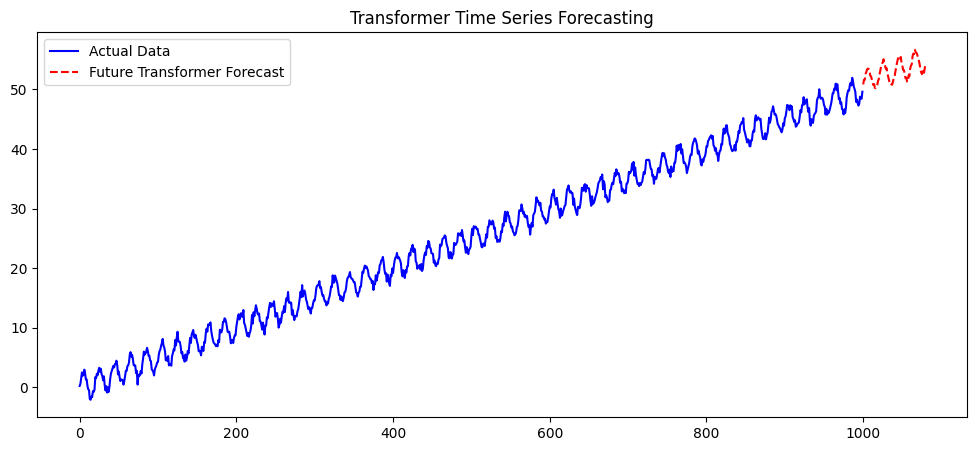

In [6]:
# 4. 미래 예측 (80개 시점 예측)
future_steps = 80
last_sequence = torch.tensor(X_train[-1:], dtype=torch.float32)
future_predictions = []
#print(last_sequence.shape)
model.eval()
with torch.no_grad():
    for _ in range(future_steps):
        next_pred = model(last_sequence).cpu().numpy()  # 예측값
        future_predictions.append(next_pred[0][0])  # 값 저장
        next_input = np.append(last_sequence.cpu().numpy()[0][1:], next_pred).reshape(1, seq_length, 1)
        last_sequence = torch.tensor(next_input, dtype=torch.float32)  # 입력 업데이트


# 7. 예측값 역변환
future_predictions = np.cumsum(future_predictions) + data[-1]  # 차분 복원

# 8. 시각화
plt.figure(figsize=(12, 5))
plt.plot(range(len(data)), data, label='Actual Data', color='blue')
plt.plot(range(len(data), len(data) + future_steps), future_predictions, label='Future Transformer Forecast', color='red', linestyle='dashed')
plt.legend()
plt.title('Transformer Time Series Forecasting')
plt.show()

In [1]:
import torch
torch.cuda.is_available()

True

### 실습1: APPLE 주식 예측 모델 개발 
2015/01/01 부터 2024/01/01 까지의 데이터로 학습하여,  
2024/01/01 부터 20일 동안의 종가를 예측하는 Transformer 모델을 구축하려고 함.  

input_size = 4 (시가, 고가, 저가, 종가)  
sequence_size (time_steps) = 20 (20일 정보를 바탕으로 다음날 주식을 예측함)  
hidden_size = 50 (cell state, hidden state보다 동일하게 50 크기의 벡터로 함)  


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. 애플 주식 데이터 로드
data = pd.read_csv("Data/apple_stock.csv", index_col='Date', parse_dates=True)
data = data[['Open', 'High', 'Low', 'Close']]
input_size = 4

# 데이터 학습용(2024-01-01까지) 및 예측 검증용(2024-02-01까지) 분리
train_data = data.loc[:"2023-11-01"]
data_pre = train_data.pct_change().dropna()
scaler = StandardScaler()
data_pre = scaler.fit_transform(data_pre)


# 3. 데이터셋 생성 함수
def create_sequences(data_array, seq_length):
    sequences, labels = [], []
    #data_array = data.to_numpy()
    for i in range(len(data_array) - seq_length):
        sequences.append(data_array[i:i+seq_length])
        labels.append(data_array[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 20  # LSTM 입력 시퀀스 길이
X, y = create_sequences(data_pre, seq_length)
X_train, y_train = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)

        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        print(pe.shape)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    

################################################
###########        실습2-1-시작        ##########
################################################
# Transformer 모델 구현
# class TransformerForecastingModel(nn.Module):

















################################################
###########        실습2-1-종료        ##########
################################################

# 3. 모델 학습
EPOCHS = 1000
LEARNING_RATE = 1e-3

# 모델 초기화
model = TransformerForecastingModel(input_size = input_size, seq_len=seq_length).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
X_train, y_train = X_train.to(device), y_train.to(device)

# 학습 루프
model.train()
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    out = model(X_train)
   
    loss = criterion(out, y_train)
    loss.backward()
    optimizer.step()
    total_loss = loss.item()
    
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss :.6f}")



torch.Size([5000, 1, 16])
Epoch 1/1000, Loss: 1.010464
Epoch 2/1000, Loss: 1.007863
Epoch 3/1000, Loss: 1.004667
Epoch 4/1000, Loss: 1.003691
Epoch 5/1000, Loss: 0.997698
Epoch 6/1000, Loss: 0.992610
Epoch 7/1000, Loss: 0.988405
Epoch 8/1000, Loss: 0.986381
Epoch 9/1000, Loss: 0.974792
Epoch 10/1000, Loss: 0.968306
Epoch 11/1000, Loss: 0.952685
Epoch 12/1000, Loss: 0.924007
Epoch 13/1000, Loss: 0.922705
Epoch 14/1000, Loss: 1.006490
Epoch 15/1000, Loss: 0.891460
Epoch 16/1000, Loss: 0.920914
Epoch 17/1000, Loss: 0.923412
Epoch 18/1000, Loss: 0.900030
Epoch 19/1000, Loss: 0.889140
Epoch 20/1000, Loss: 0.868323
Epoch 21/1000, Loss: 0.852851
Epoch 22/1000, Loss: 0.832495
Epoch 23/1000, Loss: 0.826958
Epoch 24/1000, Loss: 0.816953
Epoch 25/1000, Loss: 0.798960
Epoch 26/1000, Loss: 0.788298
Epoch 27/1000, Loss: 0.780615
Epoch 28/1000, Loss: 0.767543
Epoch 29/1000, Loss: 0.763343
Epoch 30/1000, Loss: 0.741064
Epoch 31/1000, Loss: 0.727103
Epoch 32/1000, Loss: 0.713822
Epoch 33/1000, Loss: 0.

In [36]:
# 7. 미래 데이터 예측 (마지막 시퀀스를 기반으로 10개 예측)
future_steps = 20
for i in range(100):
    last_sequence = torch.tensor(X_train[i], dtype=torch.float32).reshape((1,seq_length,input_size))
    print(last_sequence.shape)
    model.eval()
    with torch.no_grad():
        next_pred = model(last_sequence).cpu().numpy()
        print("Pred:", next_pred)
        print("True:", y_train[i])


torch.Size([1, 20, 4])
Pred: [[ 0.17058815 -0.11721497  0.76376224 -0.08346306]]
True: tensor([ 0.1491, -0.1039,  0.7149, -0.0453], device='cuda:0')
torch.Size([1, 20, 4])
Pred: [[-0.15408435  0.6213638   0.22420001  0.4290691 ]]
True: tensor([-0.0527,  0.7056,  0.2914,  0.3619], device='cuda:0')
torch.Size([1, 20, 4])
Pred: [[ 0.48840058 -0.17516989  0.21897247  0.02722277]]
True: tensor([ 0.6263, -0.2101,  0.4082,  0.1181], device='cuda:0')
torch.Size([1, 20, 4])
Pred: [[-0.09762843 -0.12287444 -0.32085714 -0.25935084]]
True: tensor([-0.0527, -0.0501, -0.4502, -0.5116], device='cuda:0')
torch.Size([1, 20, 4])
Pred: [[-0.31184098 -0.12654188  0.02907827  0.32104474]]
True: tensor([-0.7010, -0.2799, -0.0671,  0.3062], device='cuda:0')
torch.Size([1, 20, 4])
Pred: [[0.46828327 0.89737964 0.46886846 0.7410595 ]]
True: tensor([0.6706, 1.1781, 0.7985, 0.9886], device='cuda:0')
torch.Size([1, 20, 4])
Pred: [[0.8532998 1.0588033 0.7516031 0.8839261]]
True: tensor([1.0925, 1.3967, 1.0835, 1.2

C:\Users\park\AppData\Local\Temp\ipykernel_42832\4177592941.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  last_sequence = torch.tensor(X_train[i], dtype=torch.float32).reshape((1,seq_length,input_size))


torch.Size([1, 20, 4])
[[ 3.6721919e-03  1.8356545e-03  1.2574862e-03  1.5241266e-03]
 [ 5.6248242e-03  2.5624977e-03  3.5336877e-03  8.0846092e-03]
 [ 5.0344067e-03  3.6057148e-03  4.5384718e-03  5.9757050e-04]
 [-2.6815580e-03  3.1023840e-03  3.9211828e-03  5.0721662e-03]
 [-4.4323215e-03 -1.6073020e-03 -1.5031596e-03  4.0029376e-03]
 [ 1.3771603e-02  5.9408136e-03  3.9560362e-03  8.7512209e-04]
 [-2.0246156e-03 -2.8403299e-03 -2.3061120e-04  1.0043777e-03]
 [ 2.9566728e-03  2.8490468e-03  2.0670262e-03  6.1555125e-04]
 [-6.2739680e-04  2.6083549e-03  1.0943295e-03  5.1204222e-03]
 [ 5.4326928e-03  8.1640709e-04  2.7480989e-03 -7.3364750e-04]
 [-6.1248854e-04 -2.1583692e-03 -4.9444069e-03 -5.4148915e-03]
 [ 8.5760182e-04  4.1045854e-03  3.7106038e-03  9.8886024e-03]
 [ 5.4955930e-03  1.0404914e-02  6.6084233e-03  1.2324036e-02]
 [ 6.5758904e-03  2.4560802e-03  2.1958484e-03  4.3421482e-05]
 [ 3.6190988e-03  1.2114042e-03 -1.2124412e-03 -2.1654785e-04]
 [ 5.6025959e-03  1.8026500e-03 

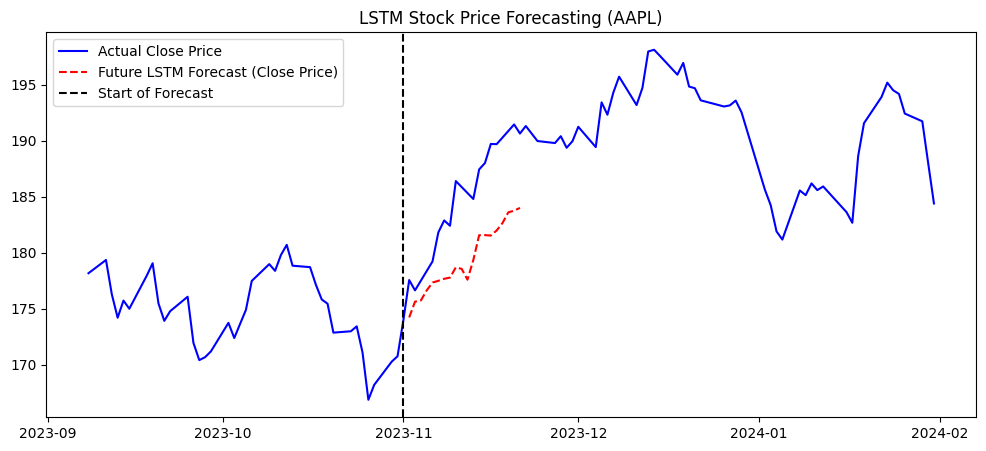

Predicted Future Prices:
                  Open        High         Low       Close
2023-11-02  171.627953  174.549830  170.333928  174.235147
2023-11-03  172.593321  174.997118  170.935840  175.643778
2023-11-04  173.462233  175.628110  171.711618  175.748742
2023-11-05  172.997085  176.172982  172.384925  176.640161
2023-11-06  172.230306  175.889819  172.125802  177.347238
2023-11-07  174.602203  176.934745  172.806745  177.502438
2023-11-08  174.248704  176.432190  172.766894  177.680710
2023-11-09  174.763893  176.934863  173.123998  177.790090
2023-11-10  174.654247  177.396362  173.313455  178.700446
2023-11-11  175.603095  177.541200  173.789743  178.569338
2023-11-12  175.495539  177.158005  172.930460  177.602402
2023-11-13  175.646042  177.885170  173.572140  179.358650
2023-11-14  176.611313  179.736056  174.719169  181.569083
2023-11-15  177.772699  180.177500  175.102823  181.576962
2023-11-16  178.416072  180.395768  174.890525  181.537642
2023-11-17  179.415665  180.720

In [ ]:

# 7. 미래 데이터 예측 (마지막 시퀀스를 기반으로 10개 예측)
future_steps = 20
last_sequence = torch.tensor(data_pre[-seq_length:,:].reshape((1,seq_length,input_size)), dtype=torch.float32).to(device)

future_predictions = []
model.eval()
with torch.no_grad():
    for _ in range(future_steps):
        next_pred = model(last_sequence).cpu().numpy()
        future_predictions.append(next_pred[0])
        next_input = np.append(last_sequence.cpu().numpy()[0][1:], next_pred).reshape(1, seq_length, input_size)
        last_sequence = torch.tensor(next_input, dtype=torch.float32).to(device)

future_predictions = np.array(future_predictions)
future_predictions = scaler.inverse_transform(future_predictions)

# 8. 예측값 역변환 및 원래 데이터 복원 (재귀적으로 적용)
future_predictions_original = [train_data.iloc[-1].values]

for pred in future_predictions:
    pred_value = future_predictions_original[-1]
    next_value = pred_value * (1 + pred)  # 상승률을 원래 값으로 변환
    future_predictions_original.append(next_value)

future_predictions_original = np.array(future_predictions_original[1:])  # 첫 번째 원본 제거
future_index = pd.date_range(start=train_data.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='D')

# 9. 시각화 (실제값과 예측값 비교)
plt.figure(figsize=(12, 5))
plt.plot(data.index[-100:], data['Close'][-100:], label='Actual Close Price', color='blue')
plt.plot(future_index, future_predictions_original[:, 3], label='Future LSTM Forecast (Close Price)', color='red', linestyle='dashed')
plt.axvline(train_data.index[-1], color='black', linestyle='--', label='Start of Forecast')
plt.legend()
plt.title('LSTM Stock Price Forecasting (AAPL)')
plt.show()

# 10. 예측 결과 출력
forecast_df = pd.DataFrame(future_predictions_original, columns=['Open', 'High', 'Low', 'Close'], index=future_index)
print("Predicted Future Prices:")
print(forecast_df)
